In [38]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from salishsea_tools import viz_tools, geo_tools
import xarray as xr
import scipy.signal as signal
import matplotlib.cm as cm
%matplotlib inline

In [2]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
new_domain = mesh.variables['tmask'][0,:,334:898,114:398]  

In [24]:
winds_data = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
atmos_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')

# y0 at 250

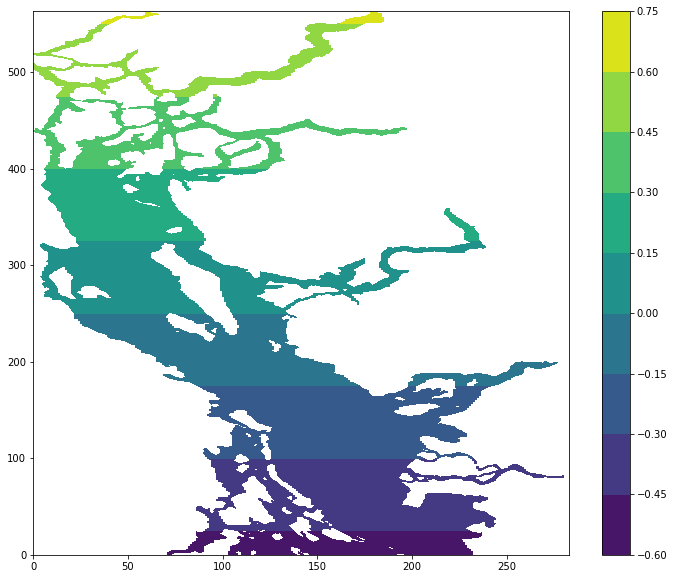

In [4]:
utau = np.zeros((564,284))
utau0=0.5
yslope= 1
y0 = 250
for y in range(564):
    for x in range(284):
        utau[y,x] = yslope*(y - y0)/y0 
utau = (utau * utau0)
fig, ax = plt.subplots(figsize=(12,10))
tau = ax.contourf(np.ma.masked_array(utau, mask = 1-new_domain[0,...]))
fig.colorbar(tau, ax=ax)

# y0 at 375

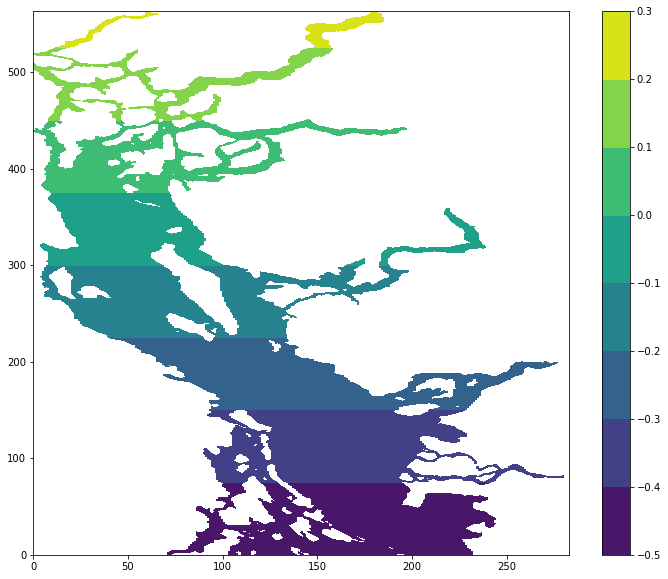

In [5]:
utau = np.zeros((564,284))
utau0=0.5
yslope= 1
y0 = 375
for y in range(564):
    for x in range(284):
        utau[y,x] = yslope*(y - y0)/y0 
utau = (utau * utau0)
fig, ax = plt.subplots(figsize=(12,10))
tau = ax.contourf(np.ma.masked_array(utau, mask = 1-new_domain[0,...]))
fig.colorbar(tau, ax=ax)

In [29]:
bathy = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
grid = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')

# Location of Stations

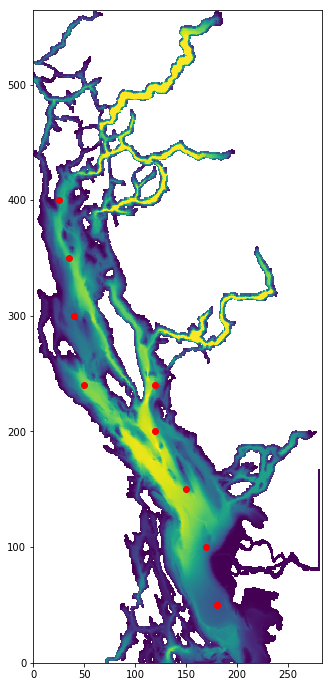

In [30]:
fig, ax = plt.subplots(1,1, figsize=(18,12))
ax.pcolormesh(np.ma.masked_array(bathy.variables['Bathymetry'][334:898,114:398], 
                                 mask = 1-new_domain[0,:,:]))
viz_tools.set_aspect(ax)
ax.plot(25,400,'ro')
ax.plot(35, 350, 'ro')
ax.plot(40, 300, 'ro')
ax.plot(120, 240, 'ro') #funny passage
ax.plot(50, 240, 'ro')
ax.plot(120, 200, 'ro')
ax.plot(150, 150, 'ro')
ax.plot(170, 100, 'ro')
ax.plot(180, 50, 'ro')

In [31]:
nemo_ji = np.array([(400, 25), (350,35), (300,40), (240,120), (250,50), (200,120), (150,150), 
                    (100,170), (50,180)]) + (335,115)

In [35]:
time_slice = slice('2017-01-01 12:00:00', '2017-07-01 12:00:00')
point = nemo_ji[0]
nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )

# Butterworth Low Pass Filter, order = 1, cutoff freq = 1/24

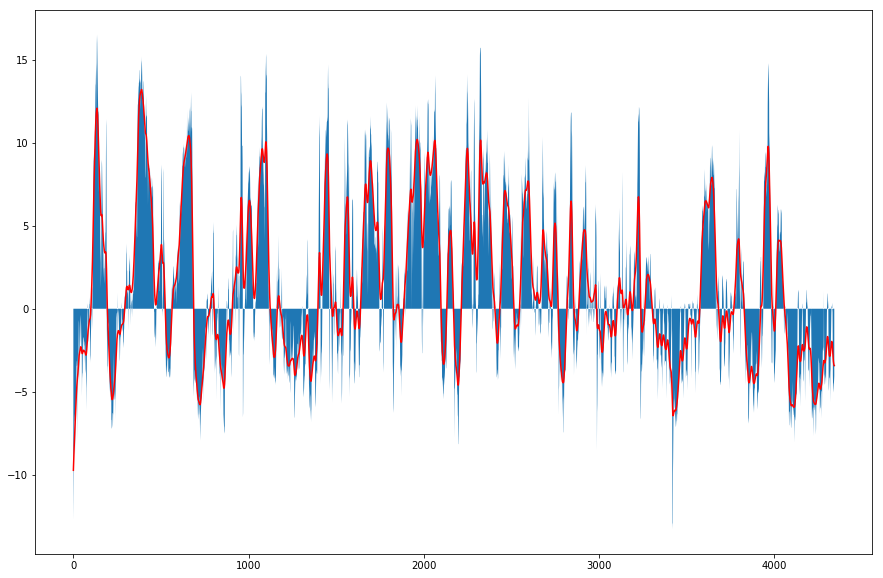

In [36]:
N  = 1    # Filter order
Wn = 1/24 # Cutoff frequency
B, A = signal.butter(N, Wn)
windf = signal.filtfilt(B,A,rotated_v_winds)
fig,ax = plt.subplots(figsize=(15,10))   #N=1, Wn = 1/24
ax.fill_between(range(4345), rotated_v_winds)
ax.plot(range(4345), windf, 'r-')

# Filtered Rotated Winds from January - July 2017

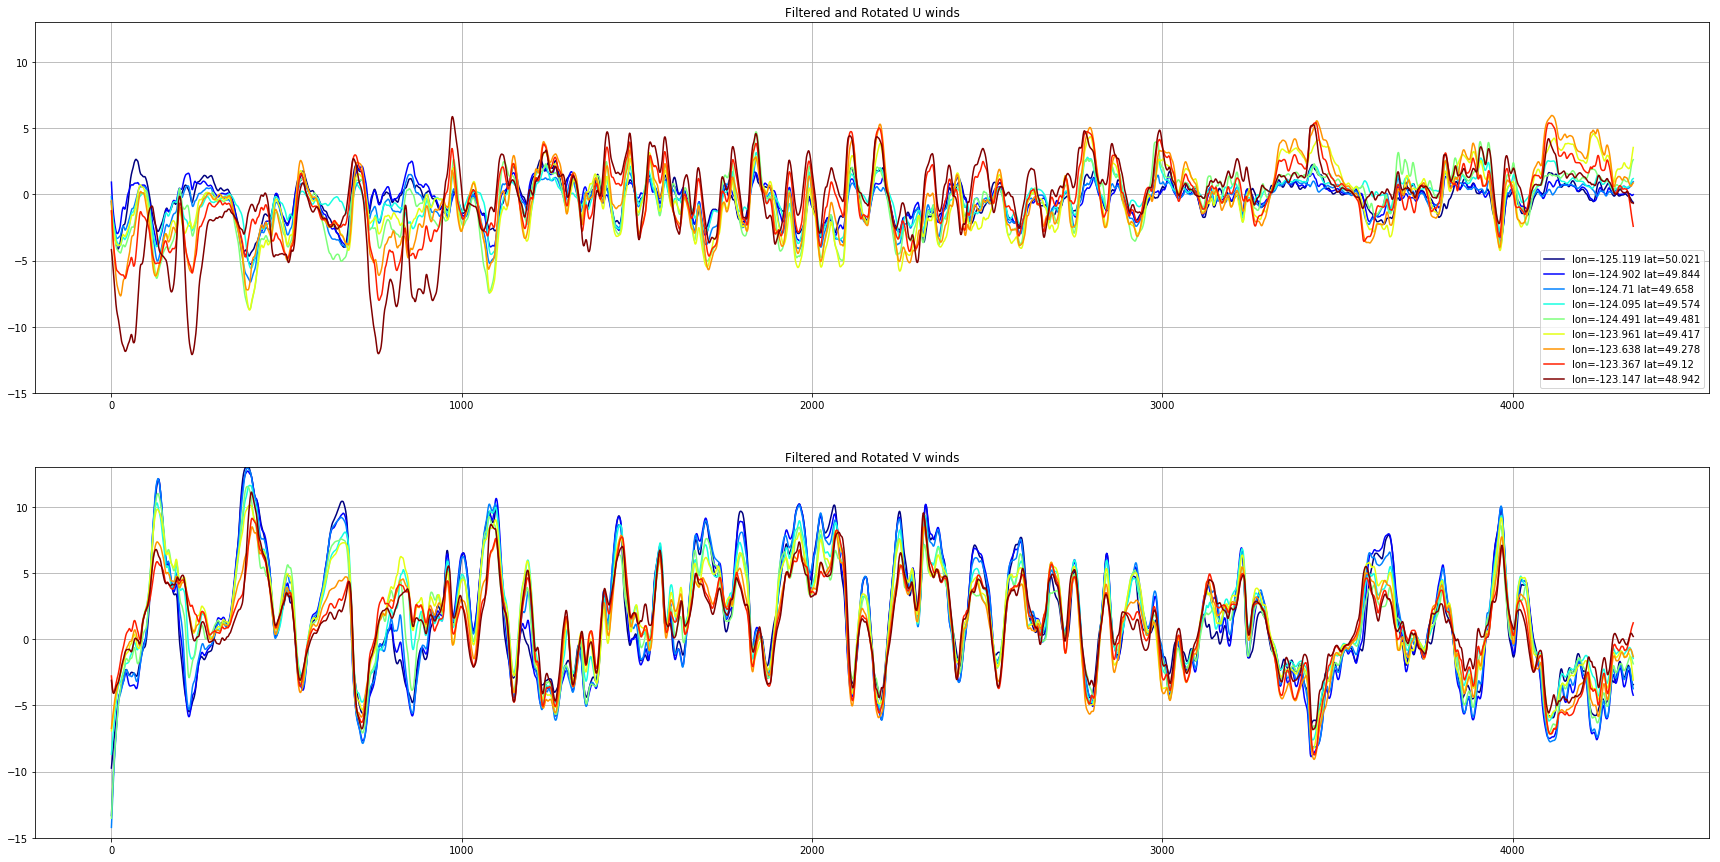

In [39]:
time_slice = slice('2017-01-01 12:00:00', '2017-07-01 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(4345), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(4345), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

# Filtered Rotated Winds from January - mid Febuary 2017

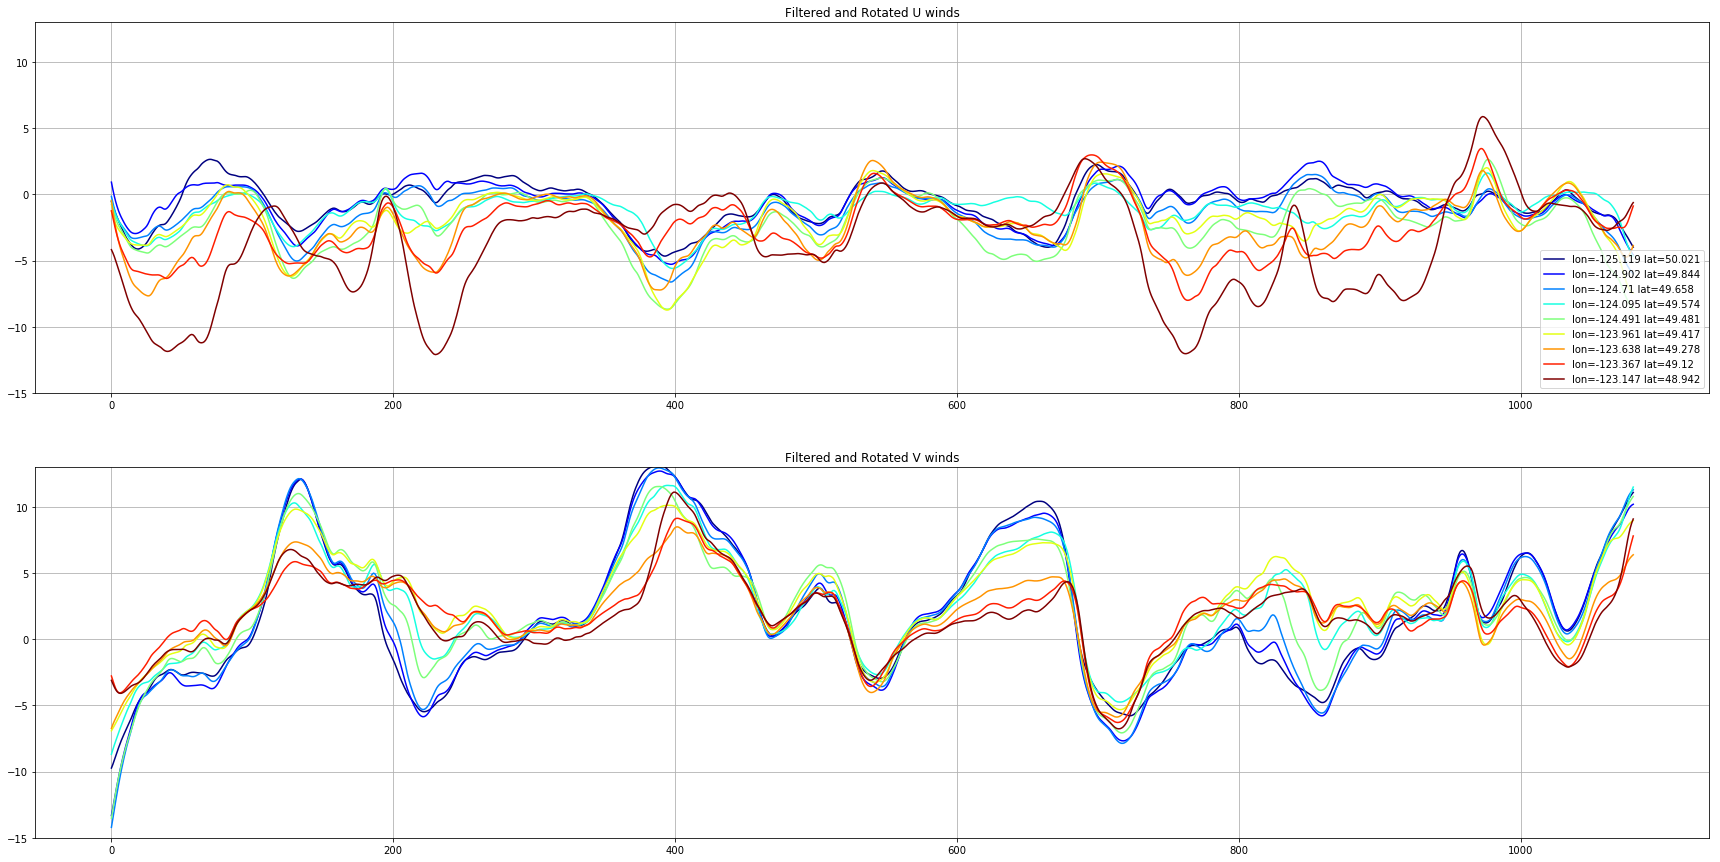

In [40]:
time_slice = slice('2017-01-01 12:00:00', '2017-02-15 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(1081), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(1081), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

# Filtered Rotated Winds from March - mid April 2017

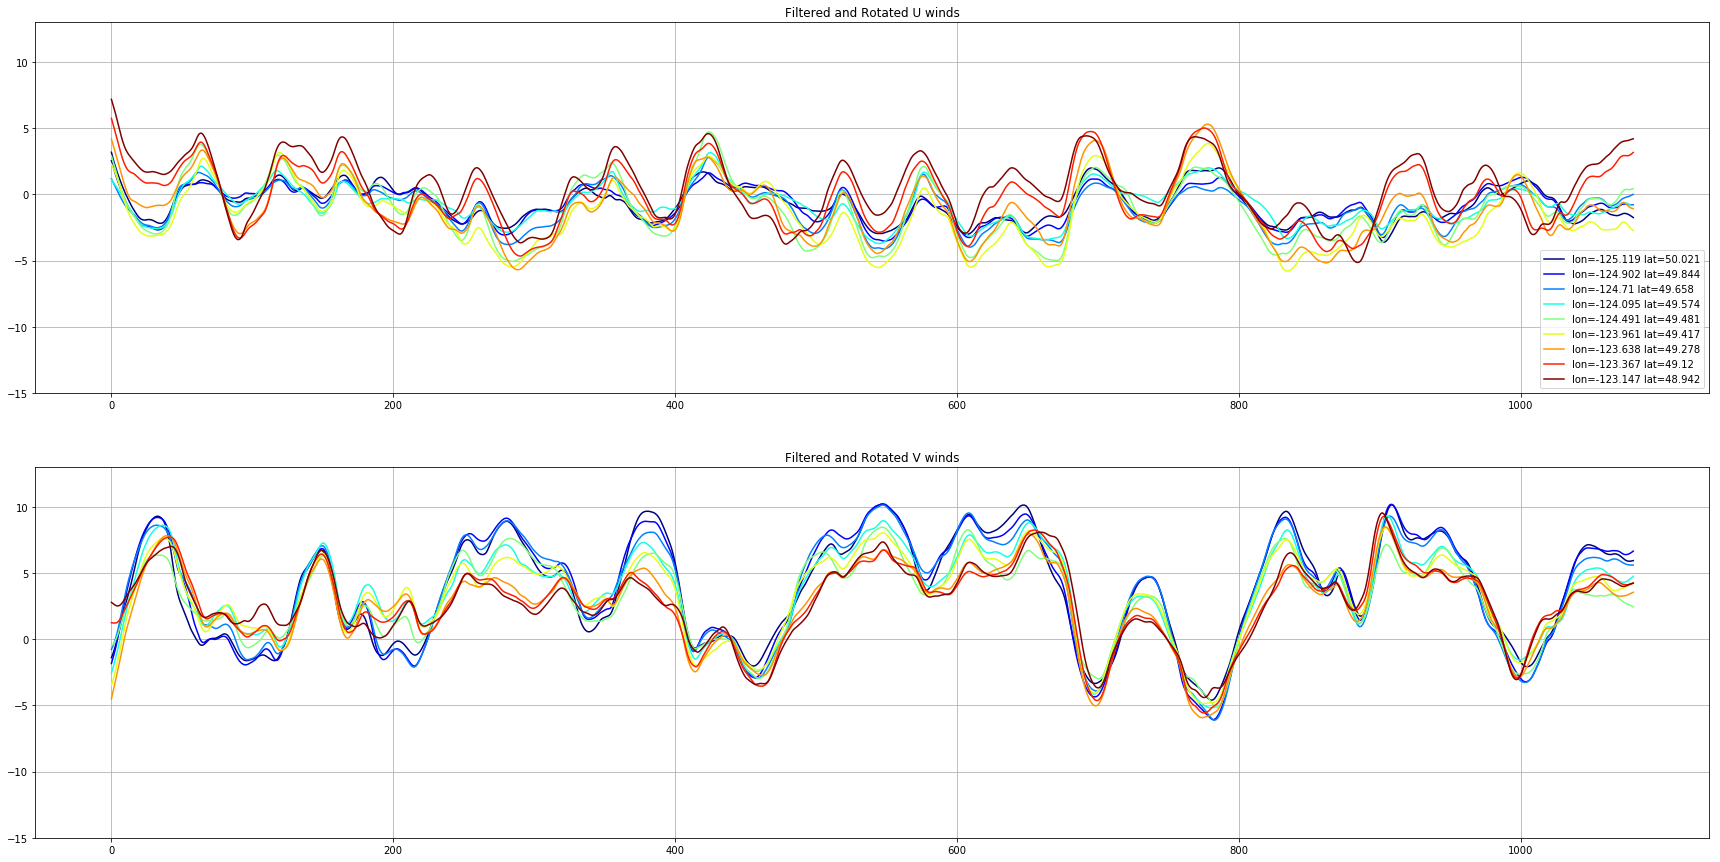

In [41]:
time_slice = slice('2017-03-01 12:00:00', '2017-04-15 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

# Filtered Rotated Winds from late May - early June 2017

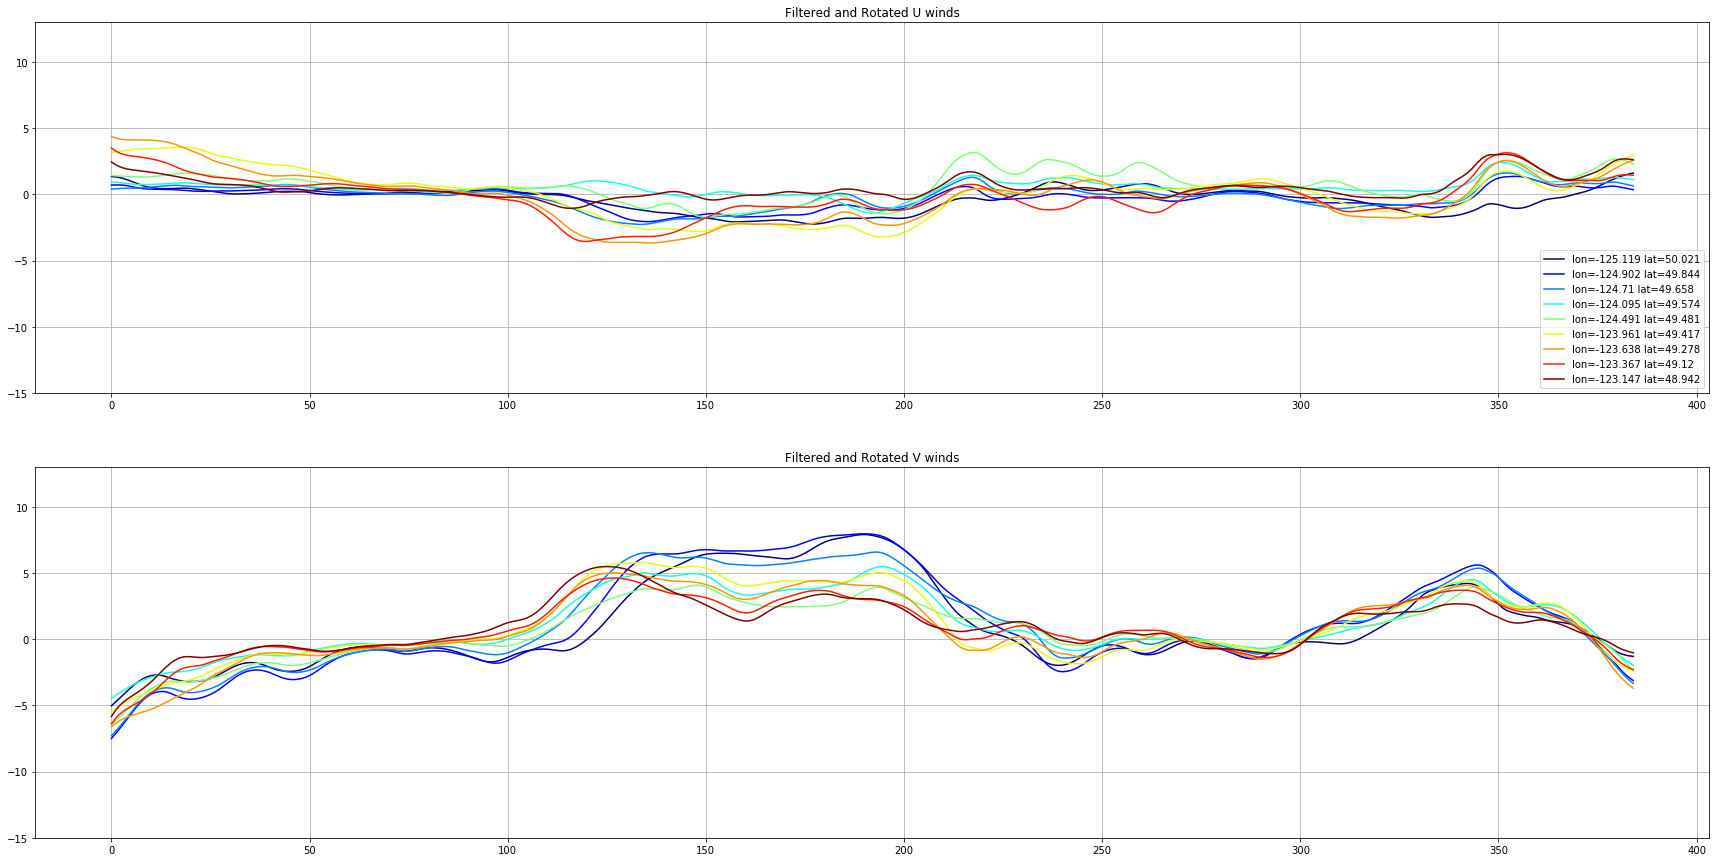

In [42]:
time_slice = slice('2017-05-25 12:00:00', '2017-06-10 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

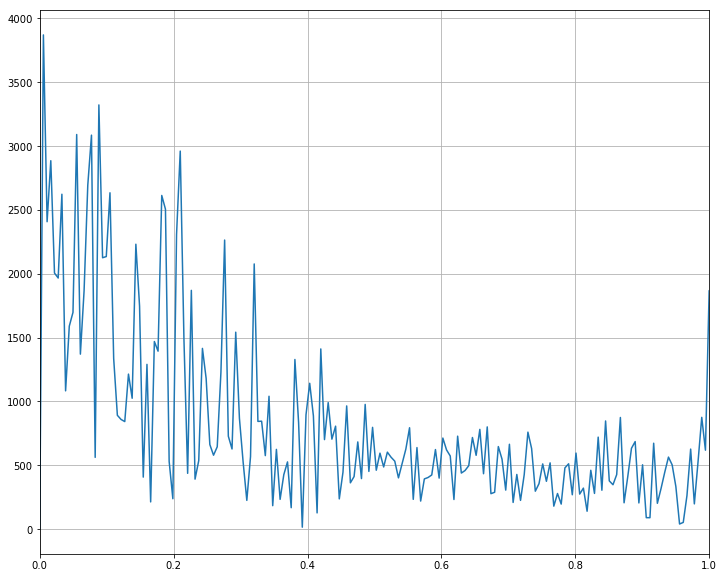

In [44]:
time_slice = slice('2017-01-01 12:00:00', '2017-07-01 12:00:00')
point = nemo_ji[0]
nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
v_freq = np.abs(np.fft.fft(rotated_v_winds- rotated_v_winds.mean()) )  
freq = np.fft.fftfreq(v_freq.shape[0], d=1/24)
fig,ax = plt.subplots(figsize=(12,10))
ax.plot(np.fft.fftshift(freq), np.fft.fftshift(v_freq))
ax.set_xlim(0,1)
ax.grid('on')